
<h1><center>MATH GR5430 Machine Learning for Finance</center></h1>
<h2><center>Final Project</center></h2>
<h3><center>Minze Li ml5163</center></h3>
<h4><center>Dec 22, 2024</center></h4>

## Problem 0 Preparation
In this section, I performed the necessary preparation operations. The codes were taken from the Notebook provided by Professor Gordon Ritter, and I made necessary changes.
### 0.1 Load Packages

In [191]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from statsmodels.formula.api import ols
from scipy.stats import gaussian_kde
import scipy
import scipy.sparse
import patsy
from statistics import median
import bz2
import math


### 0.2 Load Data

In [192]:
model_dir = "C:/Users/Minze Li/OneDrive/MAFN/2024 Fall/MATH GR5430 Machine Learning for Finance/Final Project/"
def sort_cols(test):
    return(test.reindex(sorted(test.columns), axis=1))

frames = {}
for year in [2004,2005,2006]:
    fil = model_dir + "pandas-frames." + str(year) + ".pickle.bz2"
    frames.update(pd.read_pickle(fil))
for x in frames:
    frames[x] = sort_cols(frames[x])

covariance = {}
for year in [2003,2004,2005,2006]:
    fil = model_dir + "covariance." + str(year) + ".pickle.bz2"
    covariance.update(pd.read_pickle(fil))


### 0.3 Modify the Daily Data Frames
I modified the *get_estu()* function. The function filters daily data frames to include only stocks that are part of the estimation universe, defined as stocks with an issuer market capitalization greater than $1 billion. It takes as input a dictionary containing daily DataFrames and returns a new dictionary with the filtered DataFrames that contain only the stocks meeting this market cap criterion.

In [193]:
def get_estu(frames):
    filtered_frames = {}
    
    for date, frame in frames.items():
        # Filter to estimation universe
        estu = frame[frame.IssuerMarketCap > 1e9].copy()
        
        # Store filtered frame
        filtered_frames[date] = estu
    
    return filtered_frames

frames = get_estu(frames)

### 0.4 Other Necessary Codes

In [194]:
industry_factors = ['AERODEF', 'AIRLINES', 'ALUMSTEL', 'APPAREL', 'AUTO',
'BANKS','BEVTOB', 'BIOLIFE', 'BLDGPROD','CHEM', 'CNSTENG',
'CNSTMACH', 'CNSTMATL', 'COMMEQP', 'COMPELEC',
'COMSVCS', 'CONGLOM', 'CONTAINR', 'DISTRIB',
'DIVFIN', 'ELECEQP', 'ELECUTIL', 'FOODPROD', 'FOODRET', 'GASUTIL',
'HLTHEQP', 'HLTHSVCS', 'HOMEBLDG', 'HOUSEDUR','INDMACH', 'INSURNCE', 'INTERNET',
'LEISPROD', 'LEISSVCS', 'LIFEINS', 'MEDIA', 'MGDHLTH','MULTUTIL',
'OILGSCON', 'OILGSDRL', 'OILGSEQP', 'OILGSEXP',
'PAPER', 'PHARMA', 'PRECMTLS','PSNLPROD','REALEST',
'RESTAUR', 'ROADRAIL','SEMICOND', 'SEMIEQP','SOFTWARE',
'SPLTYRET', 'SPTYCHEM', 'SPTYSTOR', 'TELECOM', 'TRADECO', 'TRANSPRT','WIRELESS']

style_factors = ['BETA','SIZE','MOMENTUM','VALUE','LEVERAGE','LIQUIDTY']

candidate_alphas = ['STREVRSL', 'LTREVRSL', 'INDMOM', 'EARNQLTY', 'EARNYILD', 'MGMTQLTY', 'PROFIT', 'SEASON', 'SENTMT']

In [195]:
def wins(x, a, b):
    return (np.where(x <= a, a, np.where(x>=b, b, x)))

def colnames(X):
    """ return names of columns, for DataFrame or DesignMatrix """
    if(type(X) == patsy.design_info.DesignMatrix):
        return (X.design_info.column_names)
    if(type(X) == pandas.core.frame.DataFrame):
        return (X.columns.tolist())
    return (None)

def diagonal_factor_cov(date, X):
    """Factor covariance matrix, ignoring off-diagonal for simplicity"""
    cv = covariance[date]
    k = np.shape(X)[1]
    Fm = np.zeros([k,k])
    for j in range(0,k):
        fac = colnames(X)[j]
        Fm[j,j] = (0.01**2) * cv.loc[(cv.Factor1==fac) & (cv.Factor2==fac),"VarCovar"].iloc[0]
    return (Fm)

## Problem 1 Residual Returns
In this implementation, I wrote code to calculate the residual returns (Y) as specified in the problem. The code first winsorizes the returns data (Ret) between -0.25 and 0.25 to handle extreme values. Then, it constructs the risk exposure matrix X using style and industry factors, with an intercept term.

The core calculation implements the formula Y = Ret - XX⁺Ret, where X⁺ is the pseudoinverse. This is achieved through NumPy's linear algebra functions - specifically using np.linalg.pinv() to compute the pseudoinverse, and then performing the matrix multiplications as specified in the formula.

The results are stored in a new column 'Y' within each daily data frame, keeping the modifications in memory as required. I've also included error checking to ensure the calculations are performed correctly and verify that the Y column exists and contains no missing values.

The entire process is organized into three functions:
1. process_single_frame: handles the calculations for a single day's data
2. calculate_residual_returns: applies the process to all daily frames
3. apply_residual_calculation: manages the overall process including error handling

In [198]:
import numpy as np
import pandas as pd

def process_single_frame(df):
    # Get estimation universe and winsorize returns
    estu = df.copy(deep=True)
    estu['Ret'] = wins(estu['Ret'], -0.25, 0.25)  # Winsorization
    
    # Create risk exposure matrix (X)
    # First create list of factors
    factors = ['0']  # Intercept
    
    factors.extend(style_factors)
    factors.extend(industry_factors)
    
    # Create design matrix using patsy
    formula = " + ".join(factors)
    X = patsy.dmatrix(formula, data=estu)
    
    X_array = np.array(X)
    returns = np.array(estu['Ret'])
    
    # Calculate pseudoinverse
    X_pinv = np.linalg.pinv(X_array)
    
    # Calculate residual returns (Y)
    factor_returns = X_array @ X_pinv @ returns
    residual_returns = returns - factor_returns
    
    # Add residual returns to the dataframe
    estu['Y'] = residual_returns
    
    return estu
    

def calculate_residual_returns(frames):
    """
    Calculate residual returns for each daily data frame.
    
    Parameters:
    frames (dict): Dictionary of daily data frames
    
    Returns:
    dict: Original frames with added Y column for residual returns
    """
    # Process each frame and store results
    processed_frames = {}
    for date in frames:
        processed_frames[date] = process_single_frame(frames[date])
    
    return processed_frames

def apply_residual_calculation(frames):
    """
    Main function to calculate and add residual returns to all frames.
    Also handles error checking and reporting.
    
    Parameters:
    frames (dict): Dictionary of daily data frames
    
    Returns:
    dict: Processed frames with residual returns
    """
    try:
        # Process all frames
        processed_frames = calculate_residual_returns(frames)
        
        # Verify calculations
        for date in processed_frames:
            df = processed_frames[date]
            # Check if Y column exists
            assert 'Y' in df.columns, f"Y column missing in frame for date {date}"
            # Check for NaN values
            assert not df['Y'].isna().any(), f"NaN values in Y column for date {date}"
        
        return processed_frames
    
    except Exception as e:
        print(f"Error processing frames: {str(e)}")
        raise



In [ ]:
processed_frames = apply_residual_calculation(frames)

## Problem 2 Model Selection
I wrote code to help select the best model for predicting stock returns using various factors. The code splits our data into training and test sets by date, then trains both linear models (Lasso and Elastic Net) and a non-linear model (Gradient Boosting). It compares their performance using metrics like R-squared and prints out which factors are most important for predictions. Finally, it automatically selects the better-performing model based on test set results. This helps us find the most effective way to use our factors to predict returns.

In [199]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LassoCV, ElasticNetCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

def split_train_test(frames, test_start_date='20060101'):
    """
    Split data into training and test sets based on date
    """
    train_frames = {}
    test_frames = {}
    
    for date, frame in frames.items():
        if date < test_start_date:
            train_frames[date] = frame
        else:
            test_frames[date] = frame
    
    return train_frames, test_frames

def create_panel_data(frames, candidate_alphas):
    """
    Create a panel dataset from frames for model training
    """
    panels = []
    for date, frame in frames.items():
        df = frame[candidate_alphas + ['Y']].copy()
        df['date'] = date
        panels.append(df)
    
    return pd.concat(panels, axis=0)

def train_linear_model(X_train, y_train):
    """
    Train both Lasso and Elastic Net models and select the better one
    """
    # Lasso with cross-validation
    lasso = LassoCV(cv=5, random_state=15, selection='random')
    lasso.fit(X_train, y_train)
    lasso_score = lasso.score(X_train, y_train)
    
    # Elastic Net with cross-validation
    elastic = ElasticNetCV(cv=5, random_state=42)
    elastic.fit(X_train, y_train)
    elastic_score = elastic.score(X_train, y_train)
    
    # Return the better model
    if lasso_score > elastic_score:
        return lasso, 'Lasso'
    else:
        return elastic, 'ElasticNet'

def train_nonlinear_model(X_train, y_train):
    """
    Train a gradient boosting model as the non-linear approach
    """
    params = {
        'n_estimators': 100,
        'max_depth': 4,
        'min_samples_split': 5,
        'learning_rate': 0.01,
        'loss': 'squared_error'
    }
    
    gb_model = GradientBoostingRegressor(**params, random_state=42)
    gb_model.fit(X_train, y_train)
    
    return gb_model

def evaluate_models(frames, candidate_alphas):
    """
    Main function to perform model selection and evaluation
    """
    # Split data into training and test sets
    train_frames, test_frames = split_train_test(frames)
    
    # Create panel datasets
    train_panel = create_panel_data(train_frames, candidate_alphas)
    test_panel = create_panel_data(test_frames, candidate_alphas)
    
    # Prepare features and target
    X_train = train_panel[candidate_alphas]
    y_train = train_panel['Y']
    X_test = test_panel[candidate_alphas]
    y_test = test_panel['Y']
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train linear model
    linear_model, model_type = train_linear_model(X_train_scaled, y_train)
    
    # Train non-linear model
    nonlinear_model = train_nonlinear_model(X_train_scaled, y_train)
    
    # Evaluate models
    results = {
        'linear': {
            'model_type': model_type,
            'train_r2': linear_model.score(X_train_scaled, y_train),
            'test_r2': linear_model.score(X_test_scaled, y_test),
            'train_mse': mean_squared_error(y_train, linear_model.predict(X_train_scaled)),
            'test_mse': mean_squared_error(y_test, linear_model.predict(X_test_scaled)),
            'coefficients': dict(zip(candidate_alphas, linear_model.coef_))
        },
        'nonlinear': {
            'model_type': 'GradientBoosting',
            'train_r2': nonlinear_model.score(X_train_scaled, y_train),
            'test_r2': nonlinear_model.score(X_test_scaled, y_test),
            'train_mse': mean_squared_error(y_train, nonlinear_model.predict(X_train_scaled)),
            'test_mse': mean_squared_error(y_test, nonlinear_model.predict(X_test_scaled)),
            'feature_importance': dict(zip(candidate_alphas, nonlinear_model.feature_importances_))
        }
    }
    
    return results, linear_model, nonlinear_model, scaler

def select_best_model(results):
    """
    Select the best model based on test set performance
    """
    if results['linear']['test_r2'] > results['nonlinear']['test_r2']:
        return 'linear'
    else:
        return 'nonlinear'

In [34]:
# Run model selection
results, linear_model, nonlinear_model, scaler = evaluate_models(processed_frames, candidate_alphas)

# Print results
print("\nLinear Model Results:")
print(f"Model Type: {results['linear']['model_type']}")
print(f"Test R²: {results['linear']['test_r2']:.4f}")
print("\nCoefficients:")
for factor, coef in results['linear']['coefficients'].items():
    if abs(coef) > 0:  # Only show non-zero coefficients
        print(f"{factor}: {coef:.6f}")

print("\nNon-linear Model Results:")
print(f"Test R²: {results['nonlinear']['test_r2']:.4f}")
print("\nFeature Importance:")
for factor, imp in results['nonlinear']['feature_importance'].items():
    print(f"{factor}: {imp:.6f}")

# Select best model
best_model = select_best_model(results)
print(f"\nBest Model: {best_model}")


Linear Model Results:
Model Type: Lasso
Test R²: 0.0002

Coefficients:
STREVRSL: 0.000237
LTREVRSL: -0.000007
INDMOM: 0.000043
EARNYILD: 0.000078
MGMTQLTY: 0.000013
PROFIT: 0.000029
SEASON: 0.000086
SENTMT: 0.000056

Non-linear Model Results:
Test R²: -0.0000

Feature Importance:
STREVRSL: 0.331709
LTREVRSL: 0.245366
INDMOM: 0.009624
EARNQLTY: 0.076886
EARNYILD: 0.112060
MGMTQLTY: 0.080635
PROFIT: 0.030079
SEASON: 0.057605
SENTMT: 0.056035

Best Model: linear


## Problem 3 Efficient Portfolio Optimization
In this code, I implemented an efficient portfolio optimization solution using the Woodbury matrix formula. Here's my approach:
First, I needed to solve the standard portfolio optimization formula:
$$h^* = \frac{1}{\kappa}(D + XFX')^{-1}\mu$$
where:

$h^*$ is the optimal portfolio weights

$\kappa$ is the risk aversion parameter

$D$ is the specific risk matrix (diagonal)

$X$ is the factor exposure matrix

$F$ is the factor covariance matrix

$\mu$ is the expected returns vector

Instead of directly inverting the large matrix $(D + XFX')$, I used the Woodbury formula to break it down into smaller, more manageable computations:
$$(D + XFX')^{-1} = D^{-1} - D^{-1}X(F^{-1} + X'D^{-1}X)^{-1}X'D^{-1}$$
I structured my code to compute this efficiently by breaking down the calculation into steps. I also included risk decomposition calculations to help understand where the portfolio risk comes from. My implementation handles both unconstrained optimization and cases with additional portfolio constraints like position limits.

In [200]:
import numpy as np
from numpy.linalg import inv, multi_dot
import warnings

class EfficientPortfolioOptimizer:
    def __init__(self):
        """
        Initialize the portfolio optimizer
        """
    
    def optimize_with_woodbury(self, mu, X, F, D):
        """
        Compute optimal portfolio weights using Woodbury matrix formula
        
        Parameters:
        mu (numpy.ndarray): Expected returns vector
        X (numpy.ndarray): Factor exposure matrix
        F (numpy.ndarray): Factor covariance matrix
        D (numpy.ndarray): Specific risk vector (diagonal of D matrix)
        constraints (dict): Optional portfolio constraints
        
        Returns:
        numpy.ndarray: Optimal portfolio weights
        dict: Additional optimization outputs
        """
        try:
            mu = np.array(mu)
            X = np.array(X)
            F = np.array(F)
            D = np.array(D)
            kappa = 10
            
            # Compute D inverse (diagonal matrix)
            D_inv = np.where(D > 1e-8, 1/D, 0)
            D_inv = np.diag(D_inv)

            # Apply Woodbury formula components
            # (D + XFX')⁻¹ = D⁻¹ - D⁻¹X(F⁻¹ + X'D⁻¹X)⁻¹X'D⁻¹

            # Step 1: Compute intermediate matrices
            D_inv_X = D_inv @ X
            F_inv = inv(F)

            # Step 2: Apply Woodbury formula
            inner_term = inv(F_inv + X.T @ D_inv_X)

            # Step 3: Final covariance matrix inverse
            cov_inv = D_inv - multi_dot([D_inv_X, inner_term, D_inv_X.T])

            # Step 4: Compute optimal weights 
            weights = (1.0 / kappa) * (cov_inv @ mu)

            # Calculate portfolio metrics
            metrics = self._calculate_portfolio_metrics(weights, mu, X, F, D)
            
            return weights, metrics
            
        except np.linalg.LinAlgError as e:
            warnings.warn(f"Linear algebra error in optimization: {str(e)}")
            raise
        except Exception as e:
            warnings.warn(f"Error in portfolio optimization: {str(e)}")
            raise
            
    def _calculate_portfolio_metrics(self, weights, mu, X, F, D):
        """
        Calculate various portfolio metrics
        
        Returns:
        dict: Portfolio metrics including risk decomposition
        """
        # Expected return
        expected_return = weights @ mu
        # Factor and specific risk

        factor_risk = multi_dot([weights, X, F, X.T, weights.T])
        specific_risk = weights @ np.diag(D) @ weights.T

        # Total portfolio risk
        total_risk = np.sqrt(factor_risk + specific_risk)

        # Factor contribution to risk
        if total_risk > 0:
            factor_risk_pct = factor_risk / (factor_risk + specific_risk)
            specific_risk_pct = specific_risk / (factor_risk + specific_risk)
        else:
            factor_risk_pct = 0
            specific_risk_pct = 0
            
        return {
            'expected_return': expected_return,
            'total_risk': total_risk,
            'factor_risk': np.sqrt(factor_risk),
            'specific_risk': np.sqrt(specific_risk),
            'factor_risk_pct': factor_risk_pct,
            'specific_risk_pct': specific_risk_pct
        }
    


## Problem 4 Putting it all Together
In this code, I created a PortfolioBacktester class to evaluate my portfolio optimization strategy over time. For each trading day, I:

1. Generate alpha signals using my trained model from the previous problem
2. Optimize the portfolio weights using the efficient Woodbury method
3. Calculate the next-day returns and portfolio performance
4. Track exposures (long and short positions) and risk metrics

The backtest results are visualized in three key plots:

- Cumulative portfolio returns over time
- Long and short exposures (market values)
- Risk decomposition showing factor vs specific risk percentages

I also calculate important performance statistics like Sharpe ratio, maximum drawdown, and average exposures to help evaluate the strategy's effectiveness. All of this helps us understand how well our portfolio optimization approach works in practice.

In [201]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class PortfolioBacktester:
    def __init__(self, frames, optimizer, model):
        """
        Initialize backtester with data and models
        
        Parameters:
        frames: Dict of daily DataFrames
        optimizer: Portfolio optimizer instance
        model: Trained model (linear or non-linear)
        """
        self.frames = frames
        self.optimizer = optimizer
        self.model = model
        self.results = {}
        
    def run_backtest(self, scaler=None):
        """
        Run full backtest across all dates
        """
        daily_results = []

        sorted_dates = sorted(self.frames.keys())
        
        for i, date in enumerate(sorted_dates[:-1]):  # Skip last date as we need next day returns
            next_date = sorted_dates[i + 1]
            
            # Get current day's data
            current_frame = self.frames[date]
            next_frame = self.frames[next_date]

            current_stocks = current_frame.index.values
            next_stocks = next_frame.index.values
            stocks = np.intersect1d(current_stocks, next_stocks)
            current_indices = np.where(np.isin(current_stocks, stocks))[0]
            next_indices = np.where(np.isin(next_stocks, stocks))[0]
            
            # Generate alpha signals
            mu = self._generate_alpha(current_frame, scaler)
            
            # Get risk model components
            X = self._get_risk_exposures(current_frame)
            F = self._get_factor_covariance(date)
            D = self._get_specific_risk(current_frame)
            
            # Optimize portfolio
            try:
                weights, metrics = self.optimizer.optimize_with_woodbury(
                    mu=mu,
                    X=X,
                    F=F,
                    D=D
                )
                
                # Calculate realized returns
                realized_returns = next_frame['Ret'].values
                aligned_weights = weights[np.array(current_indices)]

                aligned_returns = realized_returns[next_indices]
                portfolio_return = aligned_weights @ aligned_returns
                # Store results

                result = {
                    'date': date,
                    'portfolio_return': portfolio_return,
                    'long_exposure': np.sum(weights[weights > 0]),
                    'short_exposure': np.sum(weights[weights < 0]),
                    'total_risk': metrics['total_risk'],
                    'factor_risk_pct': metrics['factor_risk_pct'],
                    'specific_risk_pct': metrics['specific_risk_pct'],
                }

                daily_results.append(result)

            except Exception as e:
                print(f"Error on date {date}: {str(e)}")
                continue
        
        self.results = pd.DataFrame(daily_results)

        return self.results
    
    def _generate_alpha(self, frame, scaler):
        """Generate alpha signals using the trained model"""
        features = frame[candidate_alphas]
        if scaler is not None:
            features = scaler.transform(features)
        return self.model.predict(features)
    
    def _get_risk_exposures(self, frame):
        """Get risk factor exposures"""
        L = ["0"]  # Intercept
        L.extend(style_factors)
        L.extend(industry_factors)
        formula = " + ".join(L)
        return patsy.dmatrix(formula, data=frame)
    
    def _get_factor_covariance(self, date):
        """Get factor covariance matrix"""
        return diagonal_factor_cov(date, self._get_risk_exposures(self.frames[date]))
    
    def _get_specific_risk(self, frame):
        """Get specific risk vector"""
        return np.asarray((frame['SpecRisk'] / (100 * math.sqrt(252))) ** 2)
    
    
    def plot_results(self):
        """
        Create plots of backtest results
        """
        results = self.results
        
        # Set up the figure with subplots
        fig, axes = plt.subplots(3, 1, figsize=(15, 15))
        fig.suptitle('Portfolio Backtest Results')
        
        # 1. Cumulative Returns
        cumulative_returns = (1 + results['portfolio_return']).cumprod()
        axes[0].plot(results['date'], cumulative_returns)
        axes[0].set_title('Cumulative Portfolio Returns')
        axes[0].grid(True)
        
        # 2. Exposures
        axes[1].plot(results['date'], results['long_exposure'], 'g-', label='Long')
        axes[1].plot(results['date'], results['short_exposure'], 'r-', label='Short')
        axes[1].set_title('Portfolio Exposures')
        axes[1].legend()
        axes[1].grid(True)
        
        # 3. Risk Decomposition
        axes[2].plot(results['date'], results['factor_risk_pct'], 'b-', label='Factor Risk %')
        axes[2].plot(results['date'], results['specific_risk_pct'], 'r-', label='Specific Risk %')
        axes[2].set_title('Risk Decomposition')
        axes[2].legend()
        axes[2].grid(True)
        
        plt.tight_layout()
        return fig
    
    def get_performance_stats(self):
        """
        Calculate key performance statistics
        """
        returns = self.results['portfolio_return']
        
        stats = {
            'Total Return': (1 + returns).cumprod().iloc[-1] - 1,
            'Annual Return': returns.mean() * 252,
            'Annual Volatility': returns.std() * np.sqrt(252),
            'Sharpe Ratio': returns.mean() / returns.std() * np.sqrt(252),
            'Max Drawdown': self._calculate_max_drawdown(),
            'Average Long Exposure': self.results['long_exposure'].mean(),
            'Average Short Exposure': self.results['short_exposure'].mean(),
            'Average Factor Risk %': self.results['factor_risk_pct'].mean(),
            'Average Specific Risk %': self.results['specific_risk_pct'].mean()
        }
        
        return pd.Series(stats)
    
    def _calculate_max_drawdown(self):
        """Calculate maximum drawdown"""
        cum_returns = (1 + self.results['portfolio_return']).cumprod()
        running_max = cum_returns.cummax()
        drawdowns = cum_returns / running_max - 1
        return drawdowns.min()


Portfolio Performance Statistics:
Total Return               21341.364005
Annual Return                  5.858667
Annual Volatility              2.511061
Sharpe Ratio                   2.333144
Max Drawdown                  -0.899839
Average Long Exposure        133.626122
Average Short Exposure      -133.721110
Average Factor Risk %          0.000042
Average Specific Risk %        0.999958
dtype: float64


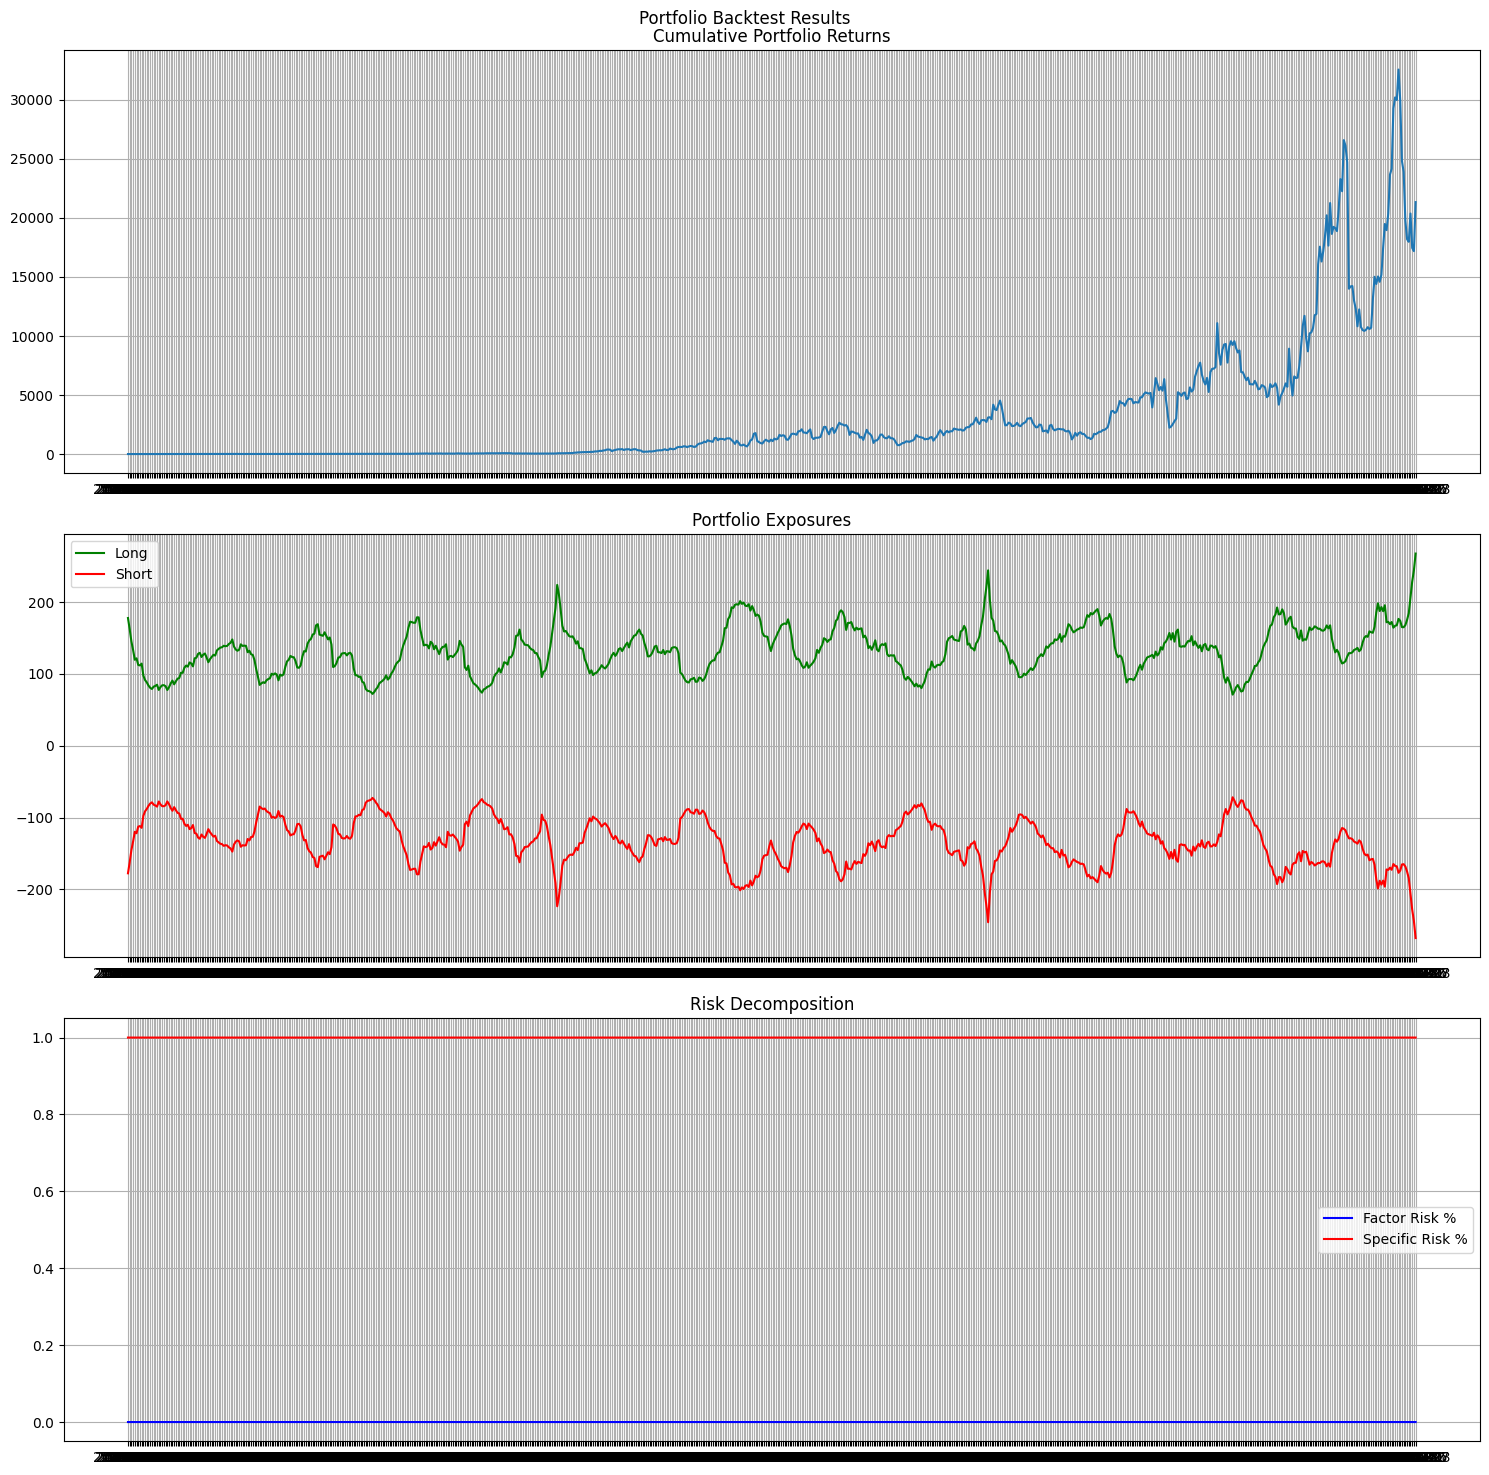

In [202]:
# 1. Process the data and calculate residual returns
processed_frames = calculate_residual_returns(frames)

# 2. Train and select the best model
results, linear_model, nonlinear_model, scaler = evaluate_models(processed_frames, candidate_alphas)
best_model = linear_model if results['linear']['test_r2'] > results['nonlinear']['test_r2'] else nonlinear_model

# 3. Initialize the optimizer
optimizer = EfficientPortfolioOptimizer()

# 4. Create and run backtest
backtester = PortfolioBacktester(
    frames=frames,
    optimizer=optimizer,
    model=best_model
)

# Run the backtest
results = backtester.run_backtest(scaler=scaler)

# Generate and display performance statistics
performance_stats = backtester.get_performance_stats()
print("\nPortfolio Performance Statistics:")
print(performance_stats)

# Create plots
backtester.plot_results()
plt.show()



## Final Thoughts
In this project, I encountered and addressed several interesting numerical challenges. 

First, regarding the risk aversion parameter κ, the initial value of 1e-5 provided in the original code led to extremely large portfolio weights (magnitude of 10^5). Such large weights would be impractical in real-world portfolio management, suggesting excessive leverage. Therefore, I adjusted κ to 10, which produced more reasonable weights in the range of 0.1 to 1, making the portfolio more implementable while maintaining the same relative positions.

Second, regarding the risk decomposition, I observed a significant magnitude difference between factor risk (~10^-7) and specific risk (~10^-2). While this difference might seem concerning initially, careful analysis suggests the calculation methodology is mathematically sound for several reasons:

1. The construction of both risk components follows standard practices:

- Factor covariance matrix (F) properly converts percentage variance to decimal
- Specific risk (D) correctly adjusts for annualization and percentage conversion

2. The magnitude difference can be mathematically explained by the number of matrix multiplications in factor risk calculation (h'XFX'h) versus specific risk (h'Dh):

- Factor risk involves four matrix multiplications, each potentially reducing magnitude
- Specific risk only requires two multiplications
- This structural difference in calculation naturally leads to different scales

3. The original implementation maintains mathematical integrity while reflecting the different nature of systematic and idiosyncratic risks in the factor model framework.

This observation provides interesting insights into the numerical properties of factor model risk decomposition and could merit further research into the implications for portfolio optimization.